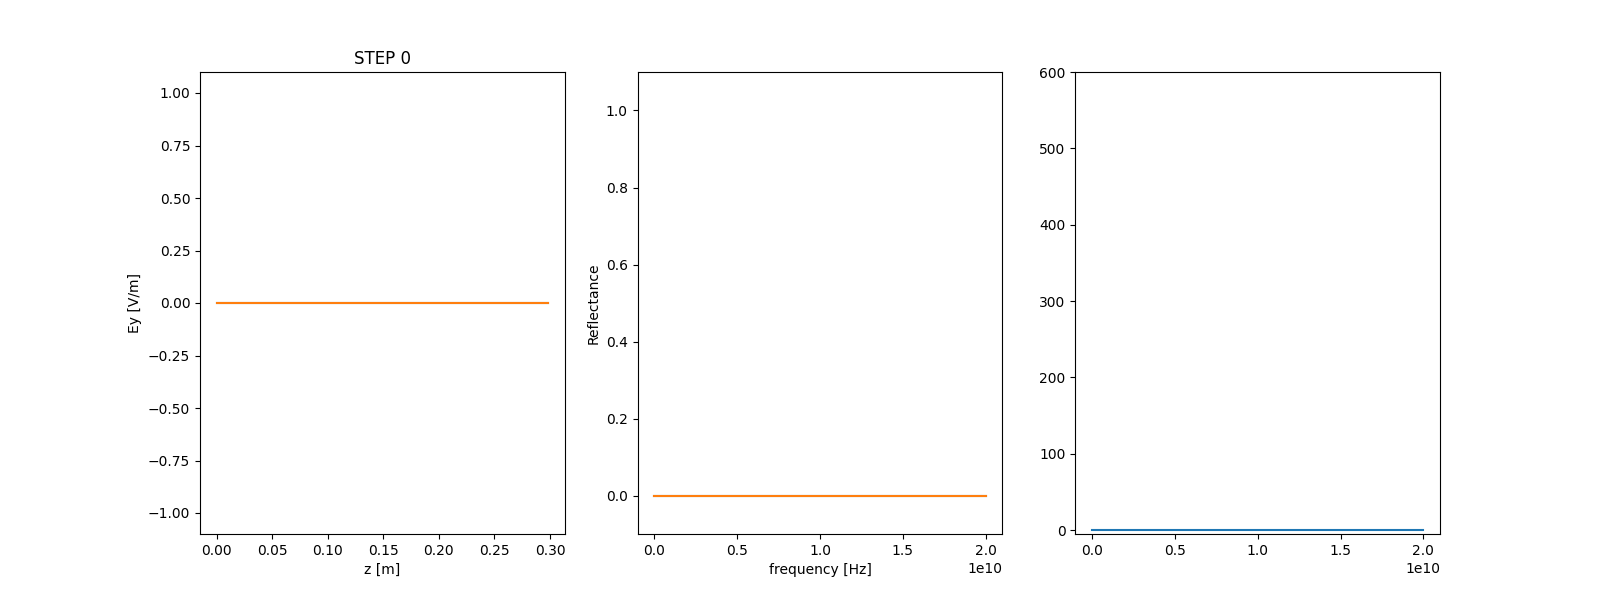

In [10]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from matplotlib.animation import FuncAnimation

def Gaussian_source(t, f_max, A): 
    tau = 1/(np.pi*f_max)
    t_0 = 5*tau
    y = A*np.exp(-((t-t_0)/tau)**2)
    return y

Nz = 200
N_time_steps = 300

f_max = 10e9
z_source = int(Nz/2)

smallest_feature_dimension = 1e-2
eps_yy = np.ones(Nz)
mu_xx = np.ones(Nz)

n = np.sqrt(mu_xx*eps_yy)

N_lam = 20
N_dim = 4
lambda_min = c/(f_max*np.max(n))
z_step = np.min([lambda_min/N_lam, smallest_feature_dimension/N_dim])
z_step = lambda_min/N_lam
z_axis = np.arange(0, z_step*Nz, z_step)

time_step = n[0]*z_step/(2*c)

mEy = c*time_step/(eps_yy*z_step)
mHx = c*time_step/(mu_xx*z_step)

time_array = np.arange(0, time_step*N_time_steps, time_step)
A = 1
g = Gaussian_source(time_array, f_max, A)

Ey = np.zeros(Nz)
Hx = np.zeros(Nz)
H1 = 0
H2 = 0
H3 = 0
E1 = 0
E2 = 0
E3 = 0

n_freq = 1000
frequencies = np.linspace(0, 2*f_max, n_freq)

K = np.exp(-1j*2*np.pi*time_step*frequencies)
reflection_spectrum = np.zeros(n_freq, dtype= "complex")
transmission_spectrum = np.zeros(n_freq, dtype= "complex")
source_spectrum = np.zeros(n_freq, dtype= "complex")

fig, ax = plt.subplots(ncols=3, figsize = (16,6))
e_field, = ax[0].plot(z_axis, Ey)
h_field, = ax[0].plot(z_axis, Hx)
title = ax[0].set_title('STEP 0')
ax[0].set_xlabel("z [m]")
ax[0].set_ylabel("Ey [V/m]")

reflection, = ax[1].plot(frequencies, reflection_spectrum)
transmission, = ax[1].plot(frequencies, transmission_spectrum)
ax[1].set_xlabel("frequency [Hz]")
ax[1].set_ylabel("Reflectance")

source, = ax[2].plot(frequencies, source_spectrum)

def animate(i):
    global Ey, Hx, H3, H2, H1, E3, E2, E1, K, time_step, reflection_spectrum, transmission_spectrum, source_spectrum
    
    Hx[0:Nz-1] = Hx[0:Nz-1] + mHx[0:Nz-1]*(Ey[1:Nz] - Ey[0:Nz-1])
    Hx[Nz-1] = Hx[Nz-1] + mHx[Nz-1]*(E3 - Ey[Nz-1])
    H3 = H2
    H2 = H1
    H1 = Hx[0]

    Ey[0] = Ey[0] + mEy[0]*(Hx[0] - H3)
    Ey[1:Nz] = Ey[1:Nz] + mEy[1:Nz]*(Hx[1:Nz] - Hx[0:Nz-1])
    E3 = E2
    E2 = E1
    E1 = Ey[Nz-1]

    Ey[z_source] = Ey[z_source] + g[i]

    e_field.set_ydata(Ey)
    h_field.set_ydata(Hx)

    source_spectrum += time_step*(K**i)*g[i]
    reflection_spectrum += np.abs(time_step*(K**i)*Ey[0])**2/np.abs(source_spectrum)**2
    transmission_spectrum += np.abs(time_step*(K**i)*Ey[Nz-1])**2/np.abs(source_spectrum)**2
    
    transmission.set_ydata(transmission_spectrum)
    reflection.set_ydata(reflection_spectrum)
    source.set_ydata(np.abs(source_spectrum)**2/time_step**2)
    title.set_text(f'STEP {i+1} OF {N_time_steps}')
    return e_field, h_field, transmission, reflection, source, 


ani = FuncAnimation(fig, animate, frames=N_time_steps, interval=16, blit=True, repeat=False)

ax[0].set_ylim([-1.1, 1.1])
ax[1].set_ylim([-0.1, 1.1])
ax[2].set_ylim([-5, 600])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from scipy.constants import epsilon_0 
from scipy.constants import mu_0

from matplotlib.animation import FuncAnimation

def Gaussian_source(t, t_0, tau, A): 
    y = A*np.exp(-((t-t_0)/tau)**2)
    return y

Nz = 500
N_time_steps = 1000

f_max = 10e14
tau = 1/(np.pi*f_max)
t_0 = 5*tau
z_source = int(Nz/2)

smallest_feature_dimension = 1e-2
eps_yy = np.ones(Nz)
mu_xx = np.ones(Nz)

n = np.sqrt(mu_xx*eps_yy)

N_lam = 20
N_dim = 4
lambda_min = c/(f_max*np.max(n))
z_step = np.min([lambda_min/N_lam, smallest_feature_dimension/N_dim])
z_step = lambda_min/N_lam
z_axis = np.arange(0, z_step*Nz, z_step)

#time_step = np.min([n[0]*z_step/(2*c), tau/20])
time_step = n[0]*z_step/(2*c)

mEy = c*time_step/(eps_yy*z_step)
mHx = c*time_step/(mu_xx*z_step)

time_array = np.array(np.arange(0, time_step*N_time_steps, time_step))
A = 1
g = Gaussian_source(time_array, t_0, tau, A)

Ey = np.zeros(Nz)
Hx = np.zeros(Nz)

fig, ax = plt.subplots()

for i in range(N_time_steps):

    Hx[0:Nz-1] = Hx[0:Nz-1] + mHx[0:Nz-1]*(Ey[1:Nz] - Ey[0:Nz-1])
    Hx[Nz-1] = Hx[Nz-1] + mHx[Nz-1]*(0 - Ey[Nz-1])

    Ey[0] = Ey[0] + mEy[0]*(Hx[0] - 0)
    Ey[1:Nz] = Ey[1:Nz] + mEy[1:Nz]*(Hx[1:Nz] - Hx[0:Nz-1])

    Ey[z_source] = Ey[z_source] + g[i]

    if i % 100 == 0:  
        ax.plot(z_axis, Ey)
        ax.set_ylim([-1.2, 1.2])


In [ ]:
# animation
Ey = np.zeros(Nz)
Hx = np.zeros(Nz)

fig, ax = plt.subplots()
line, = ax.plot(z_axis, Ey)
ax.set_ylim([-1.2, 1.2])
ax.set_xlim([0, z_step * Nz])

def update(frame):
    global Ey, Hx
    # Update Hx
    Hx[0:Nz-1] += mHx[0:Nz-1] * (Ey[1:Nz] - Ey[0:Nz-1])
    Hx[Nz-1] += mHx[Nz-1] * (0 - Ey[Nz-1])  # Boundary condition

    # Update Ey
    Ey[1:Nz] += mEy[1:Nz] * (Hx[1:Nz] - Hx[0:Nz-1])
    Ey[0] += mEy[0] * (Hx[0] - 0)  # Boundary condition

    # Add the source
    Ey[z_source] += g[frame]  # Adjust source index accordingly

    # Update the plot data
    line.set_ydata(Ey)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N_time_steps), blit=True)
ani.save('fdtd_animation.gif', dpi=120, writer="imagemagick")